In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.datasets import make_blobs

In [78]:
# Generate sample data
num_of_gaussians=3
X, _ = make_blobs(n_samples=500, centers=num_of_gaussians)


In [79]:
# ----------- Helper Functions -----------

def normalize_data(X):
    return (X - np.mean(X, axis=0)) / np.std(X, axis=0)

'''

The log-likelihood of GMM

Parameters:
X : array, shape [N, D] (Data matrix with samples as rows)
means : array, shape [K, D] (Means of the GMM)
covs: array, shape [K, D, D] (Covariance matrices of the GMM)
mixing_coefs : array, shape [K] (Mixing proportions of the GMM)
Return:
log_likelihood: float (Log-likelihood of the data under the given GMM)

'''

def gmm_log_likelihood(X, means, covs, mixing_coefs):
    n_samples = X.shape[0]
    k = num_of_gaussians
    log_likelihood = 0
    for i in range(n_samples):
        temp = 0
        for j in range(k):
            temp += mixing_coefs[j] * multivariate_normal.pdf(X[i], mean=means[j], cov=covs[j])
        log_likelihood += np.log(temp)
    return log_likelihood

In [80]:
def e_step(X, means, covs, mixing_coefs):
    n_samples = X.shape[0]
    k = num_of_gaussians
    responsibilities = np.zeros((n_samples, k))
    for j in range(k):
        responsibilities[:, j] = mixing_coefs[j] * multivariate_normal.pdf(X, mean=means[j], cov=covs[j])
    responsibilities /= responsibilities.sum(axis=1, keepdims=True)
    return responsibilities

def m_step(X, responsibilities):
    n_samples, n_features = X.shape
    k = responsibilities.shape[1]
    Nk = responsibilities.sum(axis=0)

    means = np.zeros((k, n_features))
    covs = np.zeros((k, n_features, n_features))
    mixing_coefs = Nk / n_samples

    for j in range(k):
        means[j] = (responsibilities[:, j][:, np.newaxis] * X).sum(axis=0) / Nk[j]
        diff = X - means[j]
        covs[j] = (responsibilities[:, j][:, np.newaxis, np.newaxis] *
                   np.einsum('ni,nj->nij', diff, diff)).sum(axis=0) / Nk[j]

    return means, covs, mixing_coefs

In [81]:
def plot_gmm_2d(X, responsibilities, means, covs, mixing_coefs):
    plt.figure(figsize=(8, 6))
    labels = np.argmax(responsibilities, axis=1)
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30, alpha=0.6)

    # Plot the Gaussians
    for mean, cov in zip(means, covs):
        draw_ellipse(mean, cov)
    plt.title("GMM Clustering Progress")
    plt.grid(True)
    plt.show()

def draw_ellipse(mean, cov, ax=None, color='red'):
    from matplotlib.patches import Ellipse
    if ax is None:
        ax = plt.gca()
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

    for scale in [1, 2]:
        width, height = 2 * scale * np.sqrt(vals)
        ellip = Ellipse(xy=mean, width=width, height=height,
                        angle=angle, edgecolor=color, facecolor='none', linewidth=2)
        ax.add_patch(ellip)    
    

At initialization: log-likelihood = -1701.61


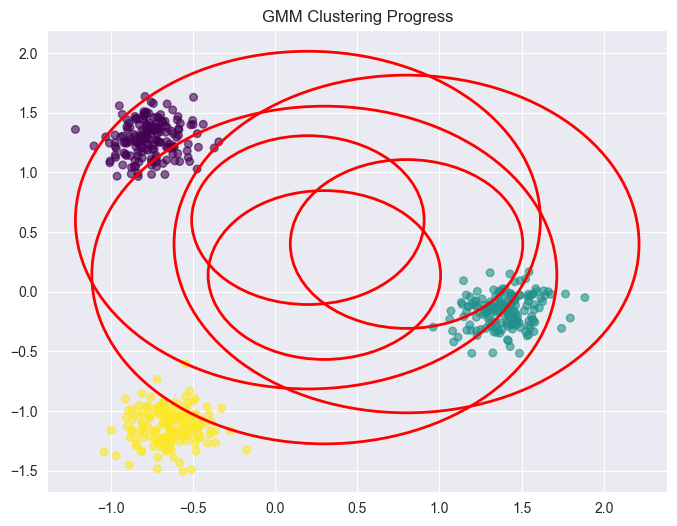

In [82]:
X_norm = normalize_data(X)
max_iters = 20

# Initial parameters, based on number of Gaussian k
means = np.array([[0.2, 0.6], [0.8, 0.4], [0.3, 0.14]])
covs = np.array([0.5 * np.eye(2), 0.5 * np.eye(2), 0.5 * np.eye(2)])
mixing_coefs = np.array([0.2, 0.5,.3])


old_log_likelihood = gmm_log_likelihood(X_norm, means, covs, mixing_coefs)
responsibilities = e_step(X_norm, means, covs, mixing_coefs)
print(f'At initialization: log-likelihood = {old_log_likelihood:.2f}')
plot_gmm_2d(X_norm, responsibilities, means, covs, mixing_coefs)

Iteration 1: log-likelihood = -1325.51, improvement = 376.10


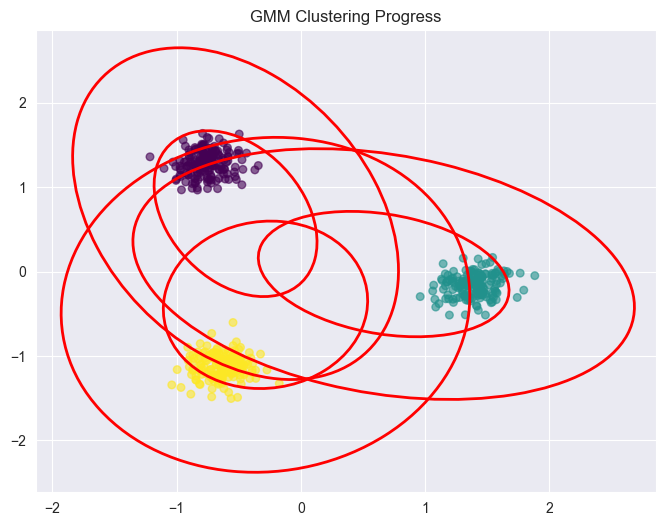

Iteration 2: log-likelihood = -1102.31, improvement = 223.20


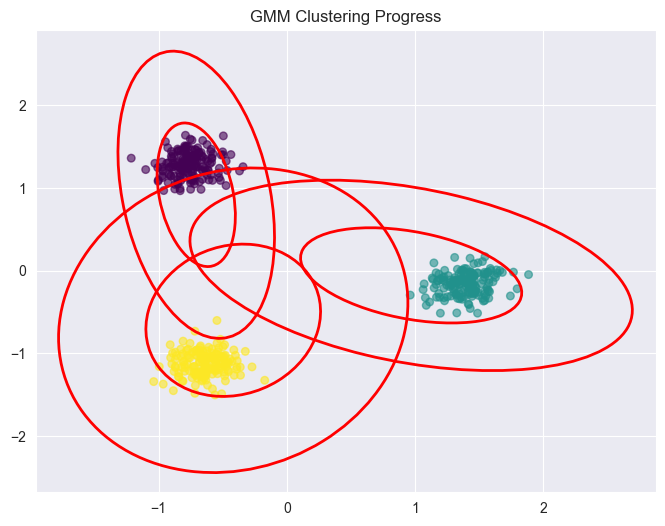

Iteration 3: log-likelihood = -608.96, improvement = 493.35


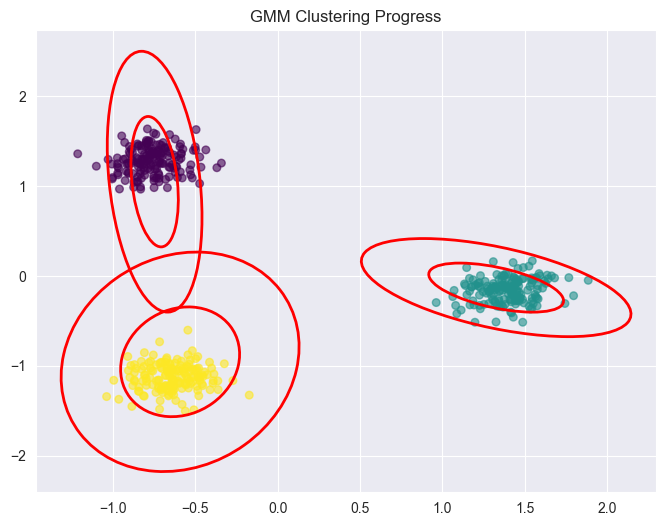

Iteration 4: log-likelihood = -113.02, improvement = 495.94


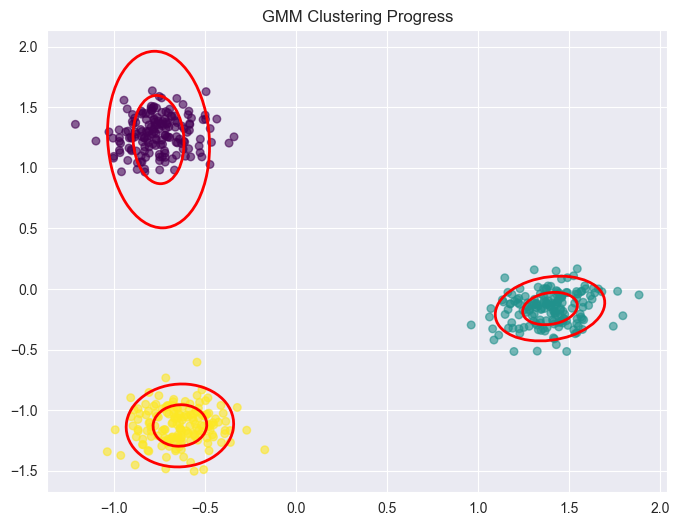

Iteration 5: log-likelihood = -23.92, improvement = 89.10


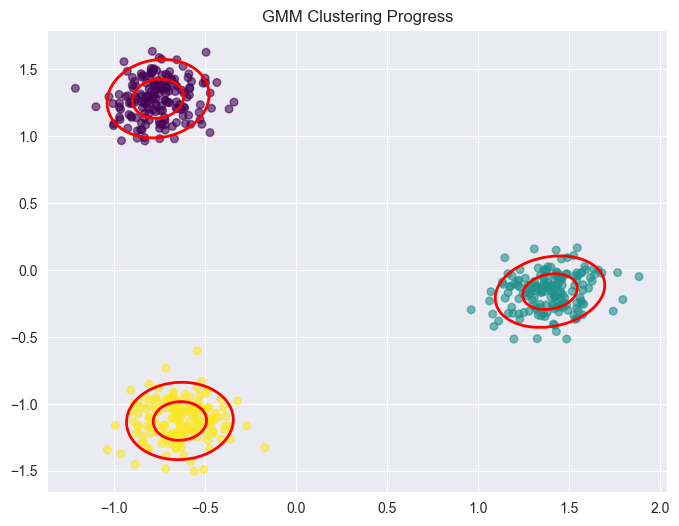

Iteration 6: log-likelihood = -23.92, improvement = 0.00


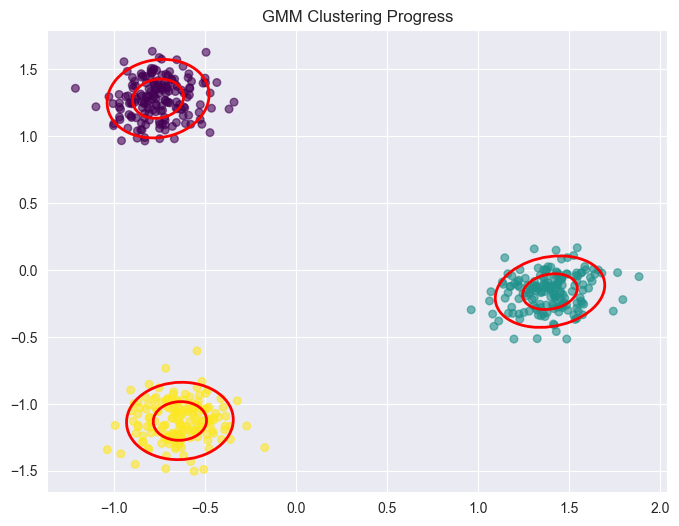

Converged after 6 iterations.


In [83]:
# EM iterations
tol = 1e-4  # convergence threshold
max_iters = 100
for i in range(max_iters):
    responsibilities = e_step(X_norm, means, covs, mixing_coefs)
    means, covs, mixing_coefs = m_step(X_norm, responsibilities)
    new_log_likelihood = gmm_log_likelihood(X_norm, means, covs, mixing_coefs)
    improvement = new_log_likelihood - old_log_likelihood

    print(f'Iteration {i+1}: log-likelihood = {new_log_likelihood:.2f}, '
          f'improvement = {new_log_likelihood - old_log_likelihood:.2f}')

    old_log_likelihood = new_log_likelihood
    plot_gmm_2d(X_norm, responsibilities, means, covs, mixing_coefs)

    #Converge if the diff is neglible 
    if np.abs(improvement) < tol:
        print(f'Converged after {i+1} iterations.')
        break

    old_log_likelihood = new_log_likelihood
else:
    print("Reached maximum iterations without full convergence.")